In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import shapely
import pyproj
import math
from shapely.ops import transform, Point, Polygon, nearest_points
from shapely.geometry import mapping

## original dataset value transformation

In [2]:
# read data and transform to wgs84

nyc_gdf = gpd.read_file('../dataframes/nycsquirrels_clean_1.csv')
nyc_gdf = gpd.GeoDataFrame(nyc_gdf, geometry=gpd.points_from_xy(nyc_gdf.long, nyc_gdf.lat))
nyc_gdf1 = nyc_gdf.set_crs('epsg:4326')

# convert fake bools (string) into 0s and 1s

behaviors = ['approaches', 'indifferent', 'runs_from', 
             'running', 'chasing', 'climbing', 'eating', 'foraging',
             'kuks', 'quaas', 'moans', 'tail_flags', 'tail_twitches']

bool_to_int = lambda x: 1 if x == 'TRUE' else 0

behavior_to_int = pd.DataFrame({behavior: nyc_gdf1[behavior].apply(bool_to_int) for behavior in behaviors})
nyc_gdf1.update(behavior_to_int)

# convert fake floats (string) to floats

long_float = nyc_gdf1['long'].apply(lambda x: float(x))
lat_float = nyc_gdf['lat'].apply(lambda x: float(x))

nyc_gdf1 = nyc_gdf1.assign(long = nyc_gdf1['long'].apply(lambda x: float(x)), 
                           lat = nyc_gdf['lat'].apply(lambda x: float(x)))
nyc_gdf1.explore()

In [3]:
html = '<p>' + str(nyc_gdf1.iloc[0]).replace('\n', '<br>') + '<p>'
str(dict(nyc_gdf1.iloc[0])).replace(', ', '\n')

"{'long': -73.95704377\n'lat': 40.79485094\n'unique_squirrel_id': '37E-PM-1006-03'\n'hectare': '37E'\n'shift': 'PM'\n'date': '10062018'\n'hectare_squirrel_number': '3'\n'age': 'Adult'\n'primary_fur_color': 'Gray'\n'combination_of_primary_and_highlight_color': 'Gray+Cinnamon'\n'location': 'Ground Plane'\n'above_ground_sighter_measurement': 'FALSE'\n'running': 1\n'chasing': 0\n'climbing': 0\n'eating': 0\n'foraging': 0\n'kuks': 0\n'quaas': 0\n'moans': 0\n'tail_flags': 0\n'tail_twitches': 0\n'approaches': 0\n'indifferent': 0\n'runs_from': 1\n'lat_long': 'POINT (-73.9570437717691 40.794850940803904)'\n'community_districts': '19'\n'borough_boundaries': '4'\n'city_council_districts': '19'\n'police_precincts': '13'\n'geometry': <shapely.geometry.point.Point object at 0x14cac75e0>}"

## add osm data

In [4]:
### load geojson datasets

centralpark = gpd.read_file('../geojson/centralpark.geojson')
water_osm = gpd.read_file('../geojson/water_cp.geojson')
stream_osm = gpd.read_file('../geojson/streams_cp.geojson')
playg_osm = gpd.read_file('../geojson/playgrounds_cp.geojson')
paved_osm = gpd.read_file('../geojson/paved.geojson')
toilets_osm = gpd.read_file('../geojson/toilets.geojson')
northbd_osm = gpd.read_file('../geojson/northbd.geojson') # cp north
jorbd_osm = gpd.read_file('../geojson/jorbd.geojson') # jacqueline kennedy onassis reservoir
greatlawnbd_osm = gpd.read_file('../geojson/greatlawnbd.geojson') # great lawn
ramblebd_osm = gpd.read_file('../geojson/ramblebd.geojson') # ramble
southbd_osm = gpd.read_file('../geojson/southbd.geojson') # cp south
met_osm = gpd.read_file('../geojson/met.geojson') # museums (MET and others outside)
gardens_osm = gpd.read_file('../geojson/gardens_cp.geojson')
woods_osm = gpd.read_file('../geojson/woods_cp.geojson')
baseball_osm = gpd.read_file('../geojson/baseballpitch.geojson')
grass_osm = gpd.read_file('../geojson/field.geojson')
barerock_osm = gpd.read_file('../geojson/bare_rock.geojson')
pedestrian_osm = gpd.read_file('../geojson/pedestrian.geojson')
sportscenter_osm = gpd.read_file('../geojson/sportscenter.geojson')

In [5]:
centralpark_poly = centralpark.take([1])
centralpark_perimeter = centralpark_poly.unary_union.convex_hull
centralpark

id               @id         amenity  \
0  relation/3005307  relation/3005307            None   
1     way/427818536     way/427818536            None   
2   node/2423633176   node/2423633176  drinking_water   
3   node/2431690843   node/2431690843  drinking_water   
4   node/2431691045   node/2431691045  drinking_water   

                             architect check_date:opening_hours heritage  \
0                                 None                     None     None   
1  Frederick Law Olmstead;Calvert Vaux               2021-05-01        2   
2                                 None                     None     None   
3                                 None                     None     None   
4                                 None                     None     None   

  heritage:operator                                   heritage:website  \
0              None                                               None   
1              nrhp  https://www.nps.gov/subjects/nationalregister/...   
2              None                                               None   
3              None                                               None   
4              None                                               None   

  leisure          name  ...  ref:nrhp    route smoking  \
0    None  Central Park  ...      None  bicycle    None   
1    park  Central Park  ...  66000538     None      no   
2    None  Central Park  ...      None     None    None   
3    None  Central Park  ...      None     None    None   
4    None  Central Park  ...      None     None    None   

                    source stateofrepair   type  \
0                     None          None  route   
1                     None          None   None   
2  Drinking Water Fountain            ok   None   
3  Drinking Water Fountain            ok   None   
4  Drinking Water Fountain            ok   None   

                          website wikidata        wikipedia  \
0                            None     None             None   
1  https://www.centralparknyc.org  Q160409  en:Central Park   
2                            None     None             None   
3                            None     None             None   
4                            None     None             None   

                                            geometry  
0  MULTILINESTRING ((-73.96456 40.79162, -73.9644...  
1  POLYGON ((-73.95770 40.80031, -73.95773 40.800...  
2                         POINT (-73.95919 40.78412)  
3                         POINT (-73.95882 40.78460)  
4                         POINT (-73.95871 40.78435)  

[5 rows x 36 columns]

In [6]:
# fix invalid geometry 
def fix_invalid(df, index):
    fixed = df.geometry[index].buffer(0)
    new_geom = df.geometry
    new_geom[index] = fixed
    df.geometry = new_geom

fix_invalid(woods_osm, 1)
fix_invalid(pedestrian_osm, 0)

cp_water = water_osm[water_osm.within(centralpark_perimeter)].assign(feature_type = 'water')
cp_stream = stream_osm[stream_osm.within(centralpark_perimeter)].assign(feature_type = 'water')
cp_playg = playg_osm[playg_osm.within(centralpark_perimeter)].assign(feature_type = 'playground')
cp_paved = paved_osm[paved_osm.within(centralpark_perimeter)].assign(feature_type = 'paved')
cp_toilets = toilets_osm[toilets_osm.within(centralpark_perimeter)].assign(feature_type = 'toilet')
cp_building = pd.concat([northbd_osm[northbd_osm.within(centralpark_perimeter)],
                         jorbd_osm[jorbd_osm.within(centralpark_perimeter)],
                         greatlawnbd_osm[greatlawnbd_osm.within(centralpark_perimeter)],
                         ramblebd_osm[ramblebd_osm.within(centralpark_perimeter)],
                         southbd_osm[southbd_osm.within(centralpark_perimeter)],
                         met_osm[met_osm.within(centralpark_perimeter)]]).assign(feature_type = 'building')
cp_garden = gardens_osm[gardens_osm.within(centralpark_perimeter)].assign(feature_type = 'garden')
cp_woods = woods_osm[woods_osm.within(centralpark_perimeter)].assign(feature_type = 'woods')
cp_baseballpitch = baseball_osm[baseball_osm.within(centralpark_perimeter)].assign(feature_type = 'baseball')
cp_grass = grass_osm[grass_osm.within(centralpark_perimeter)].assign(feature_type = 'grass')
cp_barerock = barerock_osm[barerock_osm.within(centralpark_perimeter)].assign(feature_type = 'bare rock')
cp_pedestrian = pedestrian_osm[pedestrian_osm.within(centralpark_perimeter)].assign(feature_type = 'pedestrian')
cp_sportscenter = sportscenter_osm[sportscenter_osm.within(centralpark_perimeter)].assign(feature_type = 'sports center')
centralpark['feature_type'] = 'central park'

all_features = [cp_water,
                cp_stream,
                cp_playg,
                cp_paved,
                cp_toilets,
                cp_building,
                cp_garden,
                cp_woods,
                cp_baseballpitch,
                cp_grass,
                cp_barerock,
                cp_pedestrian,
                cp_sportscenter,
                centralpark]

In [7]:
cp_allfeatures = pd.concat(all_features)
cp_allfeatures = (cp_allfeatures
                  [np.array(
                            [not isinstance(geom_object, shapely.geometry.point.Point) 
                             for geom_object in cp_allfeatures.geometry])]
                  )[['id', 'geometry', 'name', 'feature_type']].reset_index().drop(columns = 'index')

relev_features = ['building', 'garden', 'grass', 'pedestrian', 'water', 'woods']

cp_allfeatures.replace({'feature_type': 'stream'}, 'water', inplace=True)
cp_features = cp_allfeatures.query('feature_type in @relev_features').sort_values(by='feature_type').reset_index(drop=True)

## `centralparkallfeaturesmap` : map all features with legend and tag

In [8]:
cp_allfeaturesmap = folium.Map(location = [40.7823, -73.96600], 
                                       zoom_start = 14, 
                                       min_zoom = 14,
                                       tiles = 'cartodbpositron', 
                                       control_scale = True)

def to_geojson_map(df, feature, folium_map, color_var, fillOp):
    gen_stylefunc = lambda x: {'color': color_var, 'fillOpacity': fillOp}
    to_geojson = folium.GeoJson(df[df['feature_type'] == feature], name=feature, style_function=gen_stylefunc)
    to_geojson.add_to(folium_map)
    return

allfeatures = list(cp_allfeatures['feature_type'].unique())
allcolors = {'building': '#ad6f03', 
             'garden': '#ff8cec', 
             'grass': '#86b35d', 
             'pedestrian': '#000000', 
             'water': '#1795e8', 
             'stream': '#1795e8', 
             'woods': '#098f57', 
             'paved': '#000000', 
             'baseball': '#e0cdb4', 
             'playground': '#f5931b', 
             'sports center': '#960000', 
             'bare rock': '#525252', 
             'toilet': '#103b91',
             'central park': '#000000'}

for i in range(len(allfeatures)):
    to_geojson_map(cp_allfeatures, allfeatures[i], cp_allfeaturesmap, allcolors[allfeatures[i]], 0.6)

folium.LayerControl().add_to(cp_allfeaturesmap)
cp_allfeaturesmap

In [9]:
cp_featuresmap = folium.Map(location = [40.7823, -73.96600], 
                    zoom_start = 14, 
                    min_zoom = 14,
                    tiles = 'cartodbpositron', 
                    control_scale = True)

for i in range(len(relev_features)):
    to_geojson_map(cp_features, relev_features[i], cp_featuresmap, allcolors[relev_features[i]], 0.6)

folium.LayerControl().add_to(cp_featuresmap)
cp_featuresmap

## buffers - squirrels *near* feature

<AxesSubplot:ylabel='Frequency'>

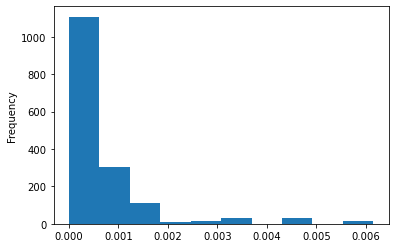

In [12]:
# area of each polygon 
planar_cpf = cp_features.to_crs('epsg:2263')
planar_cpf['area'] = planar_cpf.geometry.area
planar_cpf['inverse'] = planar_cpf['area'].apply(lambda x: 1/x if x != 0 else 0)
planar_cpf['inverse'].plot.hist(density=True)

In [13]:
def calculate_buffer_radius(area, factor, cap, base):
    # buffer_counter[0] = factor
    if area == 0:
        return base
    math_func = math.pow(area, 0.4) * factor
    if math_func > cap:
        return cap
    return math_func

buffercrs = pyproj.CRS('epsg:2263')
regcrs = pyproj.CRS('epsg:4326')
project = pyproj.Transformer.from_crs(buffercrs, regcrs, always_xy=True).transform

planar_nyc_gdf1 = nyc_gdf1.to_crs('epsg:2263')

geospatial_analysis = ['nearbuilding', 'neargarden', 'neargrass', 'nearpedestrian', 'nearwater', 'nearwoods']

# for i in range(1, 40, 1):
    # factor = i/10
    # buffer_counter = [0]
    
planar_cpf['buffer_radius'] = planar_cpf['area'].apply(calculate_buffer_radius, factor=1.2, cap=150, base=50)

buffer_geoseries = np.array([])

for i in range(len(relev_features)):
    temp = planar_cpf[planar_cpf['feature_type'] == relev_features[i]].reset_index()
    temp_array = np.array([])
    
    for j in range(len(temp)):
        temp_array = np.append(temp_array, temp.geometry[j].buffer(temp['buffer_radius'][j]))
    
    buffer_geoseries = np.append(buffer_geoseries, temp_array)
    buffer_gpd = gpd.GeoDataFrame(geometry=buffer_geoseries)
    temp_gpd = gpd.GeoDataFrame(geometry=temp_array)
    temp_planar_buffer = temp_gpd.geometry.unary_union
    # creating buffer columns
    nyc_gdf1[geospatial_analysis[i]] = planar_nyc_gdf1.within(temp_planar_buffer)
    temp_buffer = transform(project, temp_planar_buffer)
    
planar_cpf['buffer_geometry'] = buffer_gpd.geometry
buffer_cpf = planar_cpf.set_geometry('buffer_geometry').drop(columns='geometry').to_crs('epsg:4326')
buffer_cpf

id               name feature_type          area  \
0        way/265347592               None     building  1.278667e+03   
1        way/278363048               None     building  1.471465e+03   
2        way/278363046               None     building  1.644155e+03   
3        way/278363035               None     building  2.130584e+02   
4        way/278363024  Delacorte Theater     building  1.540342e+04   
..                 ...                ...          ...           ...   
202  relation/11525718               None        woods  7.860348e+05   
203  relation/11525699               None        woods  1.498455e+06   
204   relation/7893963               None        woods  3.205464e+03   
205      way/386475132               None        woods  1.499714e+03   
206      way/387382854         The Ravine        woods  7.832959e+05   

          inverse  buffer_radius  \
0    7.820646e-04      20.983803   
1    6.795948e-04      22.196332   
2    6.082150e-04      23.203762   
3    4.693549e-03      10.246621   
4    6.492063e-05      56.784285   
..            ...            ...   
202  1.272208e-06     150.000000   
203  6.673540e-07     150.000000   
204  3.119674e-04      30.306626   
205  6.667938e-04      22.365810   
206  1.276657e-06     150.000000   

                                       buffer_geometry  
0    POLYGON ((-73.98064 40.76917, -73.98070 40.769...  
1    POLYGON ((-73.96923 40.77994, -73.96923 40.779...  
2    POLYGON ((-73.96924 40.78046, -73.96924 40.780...  
3    POLYGON ((-73.96908 40.77999, -73.96902 40.779...  
4    POLYGON ((-73.96907 40.77997, -73.96908 40.779...  
..                                                 ...  
202  POLYGON ((-73.95749 40.79765, -73.95750 40.797...  
203  POLYGON ((-73.97268 40.77607, -73.97269 40.776...  
204  POLYGON ((-73.97228 40.77622, -73.97228 40.776...  
205  POLYGON ((-73.95275 40.79300, -73.95270 40.793...  
206  POLYGON ((-73.95526 40.79593, -73.95525 40.795...  

[207 rows x 7 columns]

In [14]:
# map and make dataframe


def calculate_buffer_radius(area, factor, cap, base):
    # buffer_counter[0] = factor
    if area == 0:
        return base
    math_func = math.pow(area, 0.4) * factor
    if math_func > cap:
        return cap
    return math_func


def to_featuregroup_map(df, feature, folium_map, color_var, fillOp):
    gen_stylefunc = lambda x: {'color': color_var, 'fillOpacity': fillOp}
    to_geojson = folium.GeoJson(df[df['feature_type'] == feature], name=feature, style_function=gen_stylefunc)
    to_featuregroup = folium.FeatureGroup(name=feature)
    to_geojson.add_to(to_featuregroup)
    to_featuregroup.add_to(folium_map)
    return


test_map = folium.Map(location = [40.7823, -73.96600], 
                          zoom_start = 14, 
                          min_zoom = 14,
                          tiles = 'cartodbpositron', 
                          control_scale = True)


buffercrs = pyproj.CRS('epsg:2263')
regcrs = pyproj.CRS('epsg:4326')
project = pyproj.Transformer.from_crs(buffercrs, regcrs, always_xy=True).transform

planar_nyc_gdf1 = nyc_gdf1.to_crs('epsg:2263')

geospatial_analysis = ['nearbuilding', 'neargarden', 'neargrass', 'nearpedestrian', 'nearwater', 'nearwoods']

# for i in range(1, 40, 1):
    # factor = i/10
    # buffer_counter = [0]
    
planar_cpf['buffer_radius'] = planar_cpf['area'].apply(calculate_buffer_radius, factor=1.2, cap=150, base=50)
    
for i in range(len(relev_features)):
    temp = planar_cpf[planar_cpf['feature_type'] == relev_features[i]].reset_index()
    temp_array = np.array([])
    
    for j in range(len(temp)):
        temp_array = np.append(temp_array, temp.geometry[j].buffer(temp['buffer_radius'][j]))
    
    temp_gpd = gpd.GeoDataFrame(geometry=temp_array)
    temp_planar_buffer = temp_gpd.geometry.unary_union
    nyc_gdf1[geospatial_analysis[i]] = planar_nyc_gdf1.within(temp_planar_buffer)
    temp_buffer = transform(project, temp_planar_buffer)
    
    temp_color = allcolors[relev_features[i]]
    gen_style_func = lambda x: {'color': 'b', 'fillOpacity': 0.2}
    temp_geojson = folium.GeoJson(temp_buffer, 
                                  name = relev_features[i] + ' buffer',
                                  style_function=gen_style_func).add_to(test_map)
    
for i in range(len(relev_features)):
    to_featuregroup_map(planar_cpf, relev_features[i], test_map, allcolors[relev_features[i]], 0.6)

folium.LayerControl().add_to(test_map)

buffered_nyc_df = nyc_gdf1[['long', 'lat', 'geometry'] + behaviors + geospatial_analysis].to_crs('epsg:4326')

all_squirrels = folium.FeatureGroup('all squirrels')

bfsqrls = buffered_nyc_df.query('nearbuilding == True or neargarden == True or neargrass == True or ' + 
                                'nearpedestrian == True or nearwater == True or nearwoods == True').reset_index().drop(columns='index')
for i in range(len(bfsqrls)):
    if bfsqrls.iloc[i]['nearwater'] == True or bfsqrls.iloc[i]['nearwoods'] == True:
        if bfsqrls.iloc[i]['indifferent']:
            sqrl_color = '#e3bb07'
        else:
            sqrl_color = '#453a36'
        folium.Circle(location=[bfsqrls.iloc[i]['lat'], bfsqrls.iloc[i]['long']],
                      color=sqrl_color, radius=2).add_to(test_map)
    
test_map

TypeError: Object of type Polygon is not JSON serializable

In [15]:
planar_cpf

id                                           geometry  \
0        way/265347592  POLYGON ((989592.714 219516.328, 989559.665 21...   
1        way/278363048  POLYGON ((992844.055 223454.976, 992795.611 22...   
2        way/278363046  POLYGON ((992796.378 223573.149, 992824.220 22...   
3        way/278363035  POLYGON ((992808.971 223439.807, 992805.956 22...   
4        way/278363024  POLYGON ((992932.435 223516.944, 992936.536 22...   
..                 ...                                                ...   
202  relation/11525718  POLYGON ((996490.150 229304.684, 996495.927 22...   
203  relation/11525699  POLYGON ((992509.885 222003.612, 992506.506 22...   
204   relation/7893963  POLYGON ((991908.274 222050.777, 991900.381 22...   
205      way/386475132  POLYGON ((997335.446 228170.992, 997334.873 22...   
206      way/387382854  POLYGON ((996490.150 229304.684, 996194.900 22...   

                  name feature_type          area       inverse  \
0                 None     building  1.278667e+03  7.820646e-04   
1                 None     building  1.471465e+03  6.795948e-04   
2                 None     building  1.644155e+03  6.082150e-04   
3                 None     building  2.130584e+02  4.693549e-03   
4    Delacorte Theater     building  1.540342e+04  6.492063e-05   
..                 ...          ...           ...           ...   
202               None        woods  7.860348e+05  1.272208e-06   
203               None        woods  1.498455e+06  6.673540e-07   
204               None        woods  3.205464e+03  3.119674e-04   
205               None        woods  1.499714e+03  6.667938e-04   
206         The Ravine        woods  7.832959e+05  1.276657e-06   

     buffer_radius                                    buffer_geometry  
0        20.983803  POLYGON ((989611.309 219506.604, 989595.416 21...  
1        22.196332  POLYGON ((992772.991 223430.589, 992771.801 22...  
2        23.203762  POLYGON ((992768.176 223622.808, 992767.995 22...  
3        10.246621  POLYGON ((992811.860 223449.638, 992830.805 22...  
4        56.784285  POLYGON ((992815.790 223441.498, 992813.310 22...  
..             ...                                                ...  
202     150.000000  POLYGON ((996019.446 229884.655, 996016.037 22...  
203     150.000000  POLYGON ((991816.808 222022.137, 991814.023 22...  
204      30.306626  POLYGON ((991927.185 222074.458, 991927.435 22...  
205      22.365810  POLYGON ((997332.847 228193.206, 997347.843 22...  
206     150.000000  POLYGON ((996638.056 229257.742, 996640.691 22...  

[207 rows x 8 columns]

In [16]:
bfsqrls = buffered_nyc_df.query('nearbuilding == True or neargarden == True or neargrass == True or ' + 
                                'nearpedestrian == True or nearwater == True or nearwoods == True').reset_index().drop(columns='index')
for i in range(len(bfsqrls)):
    if bfsqrls.iloc[i]['nearwater'] == True or bfsqrls.iloc[i]['nearwoods'] == True:
        if bfsqrls.iloc[i]['indifferent']:
            sqrl_color = '#e3bb07'
        else:
            sqrl_color = '#453a36'
        folium.Circle(location=[bfsqrls.iloc[i]['lat'], bfsqrls.iloc[i]['long']],
                      color=sqrl_color, radius=2).add_to(test_map)
    
test_map

NameError: name 'buffered_nyc_df' is not defined

In [ ]:
all_points = folium.FeatureGroup('all squirrels')



cp_featuresmap

In [ ]:
bfsqrls = bfsqrls.drop(columns=['long', 'lat', 'geometry'])
bfsqrls.to_csv('dataframes/bfsqrls.csv')

# k nearest neighbor, k = 5